# Gibbs chain verification

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import healpy as hp
import astropy.io.fits as fits
import camb
import scipy
import toml
import jax
import jax.numpy as jnp
import jax.lax as jlax
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from fgbuster.observation_helpers import *
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')

In [3]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'main_params/'
directory_additional_params = working_directory_path + 'additional_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


# Studying the sampling !

In [4]:
sub_step_sampling = 50
num_jobs = 1
file_ver = 'corr_fullsky_SO_d0s0_nside1_v109_v1a_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_fullsky_SO_d0s0_nside1_v1ab.toml'
## 

sub_step_sampling = 50
num_jobs = 1
file_ver = 'corr_fullsky_SO_d0s0_nside1_v109_v1b_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_fullsky_SO_d0s0_nside1_v1b.toml'
## Seems good ! Need to go further !

sub_step_sampling = 50
num_jobs = 1
file_ver = 'corr_fullsky_SO_d0s0_nside1_v109_v1bb_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_fullsky_SO_d0s0_nside1_v1bb.toml'
## Seemingly good although some patches seems to go a bit sideways

sub_step_sampling = 50
num_jobs = 1
file_ver = 'corr_fullsky_SO_d0s0_nside1_v109_v1bbb_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_fullsky_SO_d0s0_nside1_v1bbb.toml'
## 

In [5]:
fast_verion_bool = True

In [6]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

reduction_noise = dictionary_additional_parameters['reduction_noise']
# factor_Fisher = dictionary_additional_parameters['factor_Fisher']
# relative_treshold = dictionary_additional_parameters['relative_treshold']
# sigma_gap = dictionary_additional_parameters['sigma_gap']
fgs_model = dictionary_additional_parameters['fgs_model']
# initial_guess_r = dictionary_additional_parameters['initial_guess_r']
# use_nhits = dictionary_additional_parameters['use_nhits']
# name_mask = dictionary_additional_parameters['name_mask']
# use_mask = dictionary_additional_parameters['use_mask']
name_toml = dictionary_additional_parameters['name_toml']
name_file_spv = dictionary_additional_parameters['name_file_spv']
print("Using toml file: ", name_toml)

Using toml file:  corr_fullsky_SO_v1cbb.toml


In [7]:
path_toml_file = directory_toml_file + name_toml
if name_file_spv != '':
    path_file_spv = directory_toml_file + name_file_spv
else:
    path_file_spv = ''

In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file, path_file_spv)

<_io.TextIOWrapper name='/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_spatialvariability_v3/main_params/params_spv_SAT_nside1.yaml' mode='r' encoding='UTF-8'>
count_b: 8
n_betas:  8

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [1]
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f2
      default: [1]
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [1]
    f1
      default: [1]
      b0
        default: [1]
      b1
        default: [1]
      b2
        default: [1]
      b3
        default: [1]
    f2
      default: [1]
      b0
        default: [1]
      b1
        default: [1]
      b2
        default: [1]
      b3
        default: [1]


In [9]:
if (MICMAC_sampler_obj.number_iterations_sampling > 100) and (sub_step_sampling==1):
    sub_step_sampling = 50
elif MICMAC_sampler_obj.number_iterations_sampling > 1000:
    sub_step_sampling = 100
elif MICMAC_sampler_obj.number_iterations_sampling > 3000:
    sub_step_sampling = 200

In [10]:
NSIDE = MICMAC_sampler_obj.nside
# cmb_model = 'c1'
# fgs_model = 'd0s0'
# model = cmb_model+fgs_model
# noise = True
# noise = False
noise_seed = MICMAC_sampler_obj.seed
instr_name = MICMAC_sampler_obj.instrument_name

# get instrument from public database
instrument = get_instrument(instr_name)

# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=NSIDE, noise=True)[:, 1:, :]   # keep only Q and U


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise = micmac.get_noise_covar_extended(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [12]:
# input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
initial_freq_maps = []
input_cmb_maps = []
all_eta_maps = []
all_s_c_WF_maps = []
all_s_c_fluct_maps = []
all_s_c_samples = []
all_r_samples = []
all_cell_samples = []
all_params_mixing_matrix_samples = []

for job in range(num_jobs):

    initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))
    if MICMAC_sampler_obj.save_eta_chain_maps:
        all_eta_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_eta_maps.npy'
        all_eta_maps.append(np.load(all_eta_maps_path))
    
    if MICMAC_sampler_obj.save_CMB_chain_maps:
        all_s_c_WF_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_WF_maps.npy'
        all_s_c_WF_maps.append(np.load(all_s_c_WF_maps_path))

        all_s_c_fluct_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_fluct_maps.npy'
        all_s_c_fluct_maps.append(np.load(all_s_c_fluct_maps_path))


    if MICMAC_sampler_obj.sample_r_Metropolis:
        all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        all_r_samples.append(np.load(all_r_samples_path))
    elif MICMAC_sampler_obj.sample_C_inv_Wishart:
        all_cell_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_cell_samples.npy'
        all_cell_samples.append(np.load(all_cell_samples_path))

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
if MICMAC_sampler_obj.save_eta_chain_maps:
    all_eta_maps = np.array(all_eta_maps)
if MICMAC_sampler_obj.save_CMB_chain_maps:
    all_s_c_WF_maps = np.array(all_s_c_WF_maps)
    all_s_c_fluct_maps = np.array(all_s_c_fluct_maps)
if MICMAC_sampler_obj.sample_r_Metropolis:
    all_r_samples = np.array(all_r_samples)
elif MICMAC_sampler_obj.sample_C_inv_Wishart:
    all_cell_samples = np.array(all_cell_samples)
all_params_mixing_matrix_samples = np.array(all_params_mixing_matrix_samples)

In [14]:
assert MICMAC_sampler_obj.number_iterations_sampling + 1 == all_params_mixing_matrix_samples.shape[1]

In [15]:
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_{}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'.format(MICMAC_sampler_obj.instrument_name)
path_Fisher = working_directory_path+'../Fisher_matrix_{}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'.format(MICMAC_sampler_obj.instrument_name)

Fisher_matrix = np.loadtxt(path_Fisher)

jnp.array(jnp.diag(jsp.linalg.sqrtm(np.linalg.inv(Fisher_matrix))), dtype=jnp.float64)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2073: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


Array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04], dtype=float64)

In [16]:

# Getting C_approx and a first guess for C


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]


# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), 
                                                 MICMAC_sampler_obj.n_components, 
                                                 pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, 
                                                 spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b)

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(frequency_array=instrument['frequency'], 
                                        n_components=MICMAC_sampler_obj.n_components, 
                                        params=init_params,
                                        pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, 
                                        spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b, 
                                        nside=MICMAC_sampler_obj.nside)
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)

# Noise initialization
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
# BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


In [17]:
n_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = n_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [18]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter

## Testing $\eta$

In [19]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

In [20]:
all_params_mixing_matrix_samples.shape

(1, 4001, 96)

In [21]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

red_cl_noise_harm = np.zeros_like(red_cov_approx_matrix)
if MICMAC_sampler_obj.save_eta_chain_maps:
    for job in range(num_jobs):
        for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
            mixing_matrix_sampled = mixing_matrix_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            # BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

            cl_noise = BtinvNB[0,0].mean()*hp.nside2resol(MICMAC_sampler_obj.nside)**2
            red_cl_noise_harm[:] = np.diag([cl_noise,cl_noise])
            full_cl_noise = np.zeros_like(c_ell_approx)
            full_cl_noise[:MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.lmin:] = cl_noise.mean()

            # analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
            analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

            # analytical_eta_term = np.zeros_like(c_ell_approx)
            analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]

            eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[job,iteration,0,...]), all_eta_maps[job,iteration]])
            c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            plt.figure(figsize=(7,5))
            plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

            for j in range(n_correl_to_plot):
                ax = plt.subplot(311+j)
                plt.title(list_correl[j])
                
                plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')

                plt.plot(ell_arange, c_ell_approx[j,MICMAC_sampler_obj.lmin:], label='c_ell_approx')
                # plt.plot(ell_arange, full_cl_noise[j,MICMAC_sampler_obj.lmin:], label='c_ell N_c')
                plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")

                plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

                if MICMAC_sampler_obj.nstokes == 3 and j < n_correl_to_plot-2:
                    plt.xticks(color='w')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                    # plt.ylim(ymin=noise_level/10.)
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                # plt.legend()
                if j == position_legend:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
                
                plt.ylabel("$C_\ell$ [$uK^2$]")
                if j == n_correl_to_plot-1:
                    plt.xlabel(r"$\ell$")
        plt.show()

# Validation $s_c$

In [22]:
initial_freq_maps.shape

(1, 6, 2, 49152)

In [23]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if MICMAC_sampler_obj.save_CMB_chain_maps:
    for job in range(num_jobs):
        for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            
            if MICMAC_sampler_obj.sample_r_Metropolis:
                red_cov_matrix = theoretical_red_cov_r0_total + all_r_samples[job,iteration]*theoretical_red_cov_r1_tensor
            elif MICMAC_sampler_obj.sample_C_inv_Wishart:
                red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[job,iteration,...])#[MICMAC_sampler_obj.lmin:]
                if iteration != 0:
                    red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[job,iteration-1,...])#[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
            if iteration != 0:
                mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
            mixing_matrix_sampled = mixing_matrix_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            # BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
            s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]


            _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
            red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
            cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

            analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
            # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
            analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                                analytical_WF_harm, lmin=lmin, n_iter=n_iter)


            full_map_s_c = all_s_c_WF_maps[job,iteration] + all_s_c_fluct_maps[job,iteration]
            full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
            c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
            # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
            # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

            analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
            analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
            analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

            s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[job,iteration,0,...]), all_s_c_WF_maps[job,iteration]])
            c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[job,iteration,0,...]), all_s_c_fluct_maps[job,iteration]])
            c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
            s_c_recovered = all_s_c_WF_maps[job,iteration,...] + all_s_c_fluct_maps[job,iteration,...]
            s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
            c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            plt.figure(figsize=(14,8))
            plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

            for j in range(n_correl_to_plot):
                plt.subplot(331+3*j)
                plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
                plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.title('WF term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")
                plt.xlabel(r"$\ell$")
                plt.legend()

                plt.subplot(332+3*j)
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.title('Fluctuation term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")
                plt.xlabel(r"$\ell$")
                plt.legend()
                
                plt.subplot(333+3*j)
                plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")

                plt.xlabel(r"$\ell$")
                plt.legend()
        plt.show()

In [24]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if MICMAC_sampler_obj.save_CMB_chain_maps:
    for job in range(num_jobs):
        for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
            if iteration != 0:
                mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
            mixing_matrix_sampled = mixing_matrix_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
            s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]


            _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
            red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
            cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

            full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
            c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            s_c_recovered = all_s_c_WF_maps[job,iteration,...] + all_s_c_fluct_maps[job,iteration,...]
            # s_c_recovered = all_s_c_samples[iteration,...]
            s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
            c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            plt.figure(figsize=(10,5))
            plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

            for j in range(n_correl_to_plot):
                plt.subplot(311+j)
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
                plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")
                
                plt.xlabel(r"$\ell$")
                


        plt.show()

In [25]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

if not(fast_verion_bool):
    for job in range(num_jobs):
        plt.figure(figsize=(14,8))
        for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
            if iteration != 0:
                # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[MICMAC_sampler_obj.lmin:]
                mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
            mixing_matrix_sampled = mixing_matrix_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            # BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
            s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]

            # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
            full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
            c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

            plt.plot(np.arange(c_ell_s_cML.shape[-1])+lmin, c_ell_s_cML[1,:], 'g', alpha=.5)

        plt.title(f"Full $s_c$ term - {list_correl[1]} for job {job} over {num_jobs}")
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.loglog()
        plt.legend()


    plt.show()

# Plot $C$

In [26]:
if MICMAC_sampler_obj.sample_C_inv_Wishart and not(np.isnan(all_cell_samples).any()):
    job_index = 0
    nstokes_select = 1
    ell_select = 0
    burnin = 0
    selection = all_cell_samples[job_index,burnin:,nstokes_select,ell_select]

    n_sigma = 3
    transformed_samples = np.abs(selection - selection.mean())/(selection.std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_r = np.round(selection[cond].mean(), decimals=5)
    std_r = np.round(selection[cond].std(), decimals=5)

    # hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins='rice')
    hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins=1000)
    plt.plot([c_ell_true_CMB[nstokes_select,ell_select],c_ell_true_CMB[nstokes_select,ell_select]], [0,hist_nb.max()], 'r--', label='True CMB')
    plt.plot([selection.mean(),selection.mean()], [0,hist_nb.max()], '--', color='darkseagreen', label='Mean sample')
    plt.xscale('log')
    # (all_cell_samples
    plt.legend()
    plt.show()

In [27]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    any_nan = np.argwhere(np.isnan(all_cell_samples[job_index]))

    print("First nan appear :", any_nan[:MICMAC_sampler_obj.nstokes+1])

In [28]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    ell_to_probe = 10 #0
    correl = 1

    plt.figure(figsize=(14,5))
    true_CMB_ell = c_ell_true_CMB[correl,ell_to_probe]#*(2*(ell_to_probe+MICMAC_sampler_obj.lmin)+1)#**2

    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1)+1, all_cell_samples[job_index,:,correl,ell_to_probe])
    plt.plot([-1,MICMAC_sampler_obj.number_iterations_sampling+1], [true_CMB_ell,true_CMB_ell], label='True CMB')

    plt.xlabel("Iteration")
    plt.ylabel(r"$C_\ell$ [$uK^2$]")
    plt.loglog()
    # plt.ylim(ymin=0.00015, ymax=0.00017)
    plt.legend()
    plt.show()


In [29]:
input_cmb_maps.shape

(1, 6, 2, 49152)

In [30]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    plt.plot(ell_arange, all_cell_samples[job_index,721].T)
    plt.loglog()
    plt.show()

In [31]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    plt.plot(ell_arange[75:85], all_cell_samples[job_index,722,:,75:85].T)

    # plt.loglog()
    plt.yscale('log')
    plt.show()

In [32]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    for job in range(num_jobs):
        input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[job,0,0]),input_cmb_maps[job,0]])
        cmb_anafast = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

        dict_color = {'fill': 'moccasin', 'border': 'orange'}
        dict_color_theoretical = {'fill': 'lightcoral', 'border': 'tab:red'}
        # curve_theoretical = cmb_anafast
        # std_theoretical = cmb_anafast*np.sqrt(2/(2*ell_arange+1))# Knox cosmic covariance
        c_ell_mean = np.mean(all_cell_samples[job], axis=0)
        # c_ell_mean = np.mean(all_cell_samples[500:], axis=0)
        # c_ell_mean = np.mean(all_cell_samples[-2:], axis=0)

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
        factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
        factor[0] = 1
        # factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2))
        # factor = ell_arange*(ell_arange+1)/(2*np.pi)
        plt.figure(figsize=(15,10))
        for j in range(n_correl_to_plot):
            plt.subplot(311+j)
            plt.title(list_correl[j])
            if j > MICMAC_sampler_obj.nstokes-1:
                plt.title(list_correl[j] + ' with incorrect ell=2 !')

            curve_theoretical = cmb_anafast[j]
            std_theoretical = cmb_anafast[j]*np.sqrt(2/(2*ell_arange+1))
            plt.plot(ell_arange, curve_theoretical, color=dict_color_theoretical['border'], label='Anafast CMB $\pm$ Knox')
            plt.fill_between(ell_arange, curve_theoretical-std_theoretical, curve_theoretical+std_theoretical, color=dict_color_theoretical['fill'], alpha=0.2)
            plt.plot(ell_arange, curve_theoretical-std_theoretical, color=dict_color_theoretical['border'], alpha=0.6)
            plt.plot(ell_arange, curve_theoretical+std_theoretical, color=dict_color_theoretical['border'], alpha=0.6)

            plt.plot(ell_arange, c_ell_mean[j]/factor, '--', color=dict_color['border'], label='Mean value samples C')
            
            curve = c_ell_mean[j]
            std_curve = np.std(all_cell_samples[job,:,j,...], axis=0)

            plt.fill_between(ell_arange, (curve-std_curve)/factor, (curve+std_curve)/factor, color=dict_color['fill'], alpha=0.2)
            plt.plot(ell_arange, (curve-std_curve)/factor, color=dict_color['border'], alpha=0.6)
            plt.plot(ell_arange, (curve+std_curve)/factor, color=dict_color['border'], alpha=0.6)
            plt.plot(ell_arange, c_ell_true_CMB[j], color='tab:blue', label='True CMB')

            if j < MICMAC_sampler_obj.nstokes:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.loglog()
            plt.legend()
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
    plt.show()

In [33]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    for job in range(num_jobs):
        dict_color = {'fill': 'moccasin', 'border': 'orange'}

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
        # factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
        plt.figure(figsize=(15,10))
        for j in range(n_correl_to_plot):
            plt.subplot(311+j)
            plt.title(list_correl[j])

            plt.plot(ell_arange, c_ell_true_CMB[j], label='True CMB')
            for ell in range(c_ell_mean.shape[1]):
                plt.plot(ell_arange[ell]*np.ones(MICMAC_sampler_obj.number_iterations_sampling+1), all_cell_samples[job,:,j,ell], '.', color=dict_color['border'], alpha=0.1)
            # plt.plot(ell_arange, all_cell_samples[:,j,:].T, '.', color=dict_color['border'], label='Mean value samples C')

            if j < MICMAC_sampler_obj.nstokes:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.loglog()
            plt.legend()
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
    plt.show()

# Studying $r$

(3988,) 4000


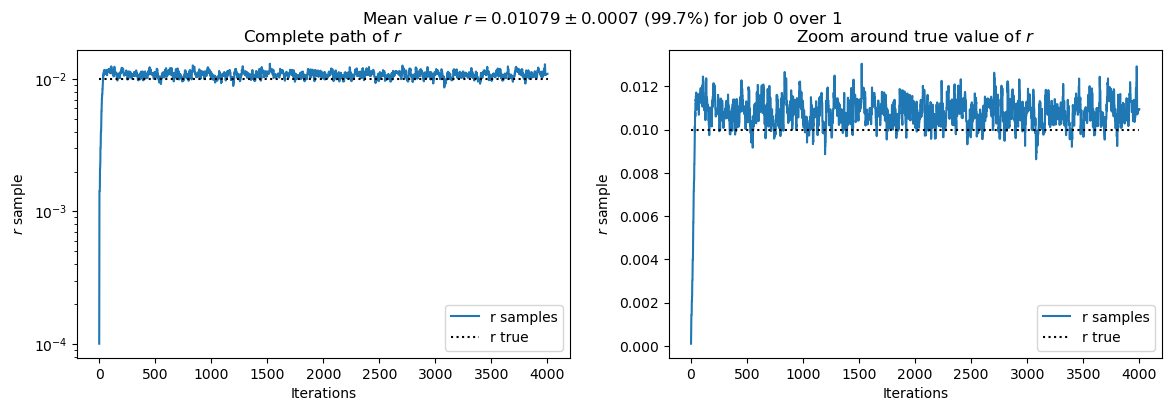

In [34]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        plt.figure(figsize=(14,4))
        
        # n_sigma = 3
        
        # cond = np.abs((all_r_samples[job] - all_r_samples[job].mean())/(all_r_samples[job].std())) < n_sigma
        cond = np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > MICMAC_sampler_obj.number_iterations_sampling + 1 - int(MICMAC_sampler_obj.number_iterations_sampling*0.9973)
        print(all_r_samples[job,cond].shape, MICMAC_sampler_obj.number_iterations_sampling)
        mean_r = np.round(all_r_samples[job,cond].mean(), decimals=5)
        std_r = np.round(all_r_samples[job,cond].std(), decimals=5)

        plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%) for job {job} over {num_jobs}")
        plt.subplot(121)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples[job], label='r samples')
        plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')

        plt.yscale('log')
        plt.xlabel("Iterations")
        plt.ylabel('$r$ sample')
        plt.title('Complete path of $r$')
        plt.legend()

        plt.subplot(122)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples[job], label='r samples')
        plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
        plt.xlabel("Iterations")
        plt.ylabel('$r$ sample')
        plt.title('Zoom around true value of $r$')
        plt.legend()
        # plt.ylim(ymin=MICMAC_sampler_obj.r_true*.7, ymax=MICMAC_sampler_obj.r_true*1.3)
    plt.show()

In [35]:
# all_r_samples[2000:].mean(), all_r_samples[2000:].std()

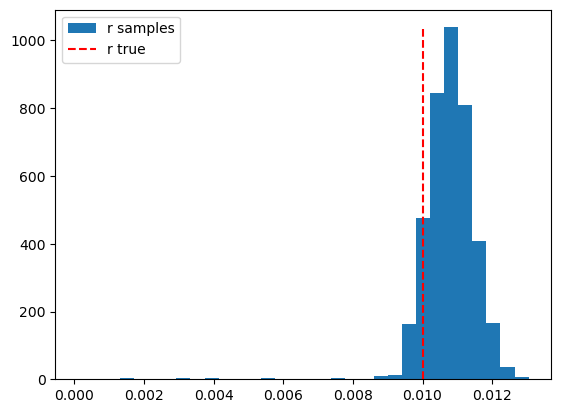

In [36]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        plt.figure()
        hist_values, bins_value, _ = plt.hist(all_r_samples[job], bins='rice', label='r samples')
        plt.plot([MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
        plt.legend()
    plt.show()

In [37]:
np.arange(8).reshape(4,2), np.arange(8).reshape(4,2).reshape(4,2,order='F')

(array([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]]),
 array([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]]))

In [38]:
# if MICMAC_sampler_obj.sample_r_Metropolis:
#     for job in range(num_jobs):
        
#         n_sigma = 3

#         old_cond = np.abs((all_r_samples[job] - all_r_samples[job].mean())/(all_r_samples[job].std())) < n_sigma
#         new_cond = np.logical_and(old_cond, np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > 2000)
#         mean_r = np.round(all_r_samples[job,new_cond].mean(), decimals=5)
#         std_r = np.round(all_r_samples[job,new_cond].std(), decimals=5)

#         print("r estimates post burn-in: {} +/- {}".format(mean_r, std_r))

#         # selection_2 = all_r_samples[np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > 3000]
#         # mean_r_2 = np.round(selection_2.mean(), decimals=5)
#         # std_r_2 = np.round(selection_2.std(), decimals=5)

#         # print("r estimates post burn-in: {} +/- {}".format(mean_r_2, std_r_2))


In [39]:
number_parameters_B_f_samples = all_params_mixing_matrix_samples.shape[-1]
number_params_B_f_nside0 = (MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))*(MICMAC_sampler_obj.n_components-1)

In [40]:
MICMAC_sampler_obj.len_params

96

In [41]:
MICMAC_sampler_obj.size_patches.cumsum()

Array([12, 24, 36, 48, 60, 72, 84, 96], dtype=int64)

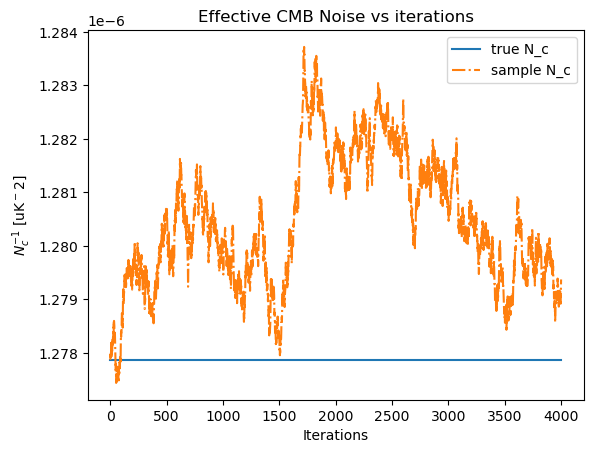

In [42]:
mixing_matrix_obj.update_params(init_params)
mixing_matrix_sampled = mixing_matrix_obj.get_B()
BtinvNB_true = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)

# if number_parameters_B_f_samples == number_params_B_f_nside0:
for job in range(num_jobs):
    all_mixing_matrix = np.zeros((MICMAC_sampler_obj.number_iterations_sampling+1,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_components))

    all_mixing_matrix[:,:,0] = mixing_matrix_sampled[:,0,0]
    all_mixing_matrix[:,0,:] = mixing_matrix_sampled[0,:,0]
    all_mixing_matrix[:,-1,:] = mixing_matrix_sampled[-1,:,0]
    
    cumsum_size_patches = np.zeros(MICMAC_sampler_obj.size_patches.shape[0]+1, dtype=int)
    cumsum_size_patches[1:] = MICMAC_sampler_obj.size_patches.cumsum()
    for i in range((MICMAC_sampler_obj.size_patches.shape[0])):
        all_mixing_matrix[:,i%(MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))+1, i//(MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))+1] = all_params_mixing_matrix_samples[job,:,cumsum_size_patches[i]:cumsum_size_patches[i+1]].mean(axis=1)
    # all_mixing_matrix[:,1:-1,1] = all_params_mixing_matrix_samples[job,:,:MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs)]
    # all_mixing_matrix[:,1:-1,2] = all_params_mixing_matrix_samples[job,:,MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs):]



    true_N_c = BtinvNB_true[0,0]
    cl_noise_harm_0 = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin]
    all_inv_N_c = jnp.linalg.pinv(jnp.einsum("ifc,fh,ihd->icd", all_mixing_matrix, MICMAC_sampler_obj.freq_inverse_noise.mean(axis=2), all_mixing_matrix))[:,0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # all_inv_N_c = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, iteration_mixing_matrix.mean(axis=2))[0,0]
    plt.figure()
    plt.title('Effective CMB Noise vs iterations')
    # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [true_N_c,true_N_c], label='true N_c')
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [cl_noise_harm_0,cl_noise_harm_0], label='true N_c')
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_inv_N_c, '-.', label='sample N_c')

    plt.xlabel('Iterations')
    plt.ylabel('$N_c^{-1}$ [uK$^-2$]')
    # plt.loglog()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
plt.show()

In [43]:
# list_correl = ['EE', 'BB', 'EB']

# ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

# frequency_Bf = instrument['frequency'][1:-1]
# all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
# all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

# frequency_array = np.array(instrument['frequency'])


# plt.figure(figsize=(14,4))
# plt.suptitle('Mixing matrix parameters sampled vs iterations')
# plt.subplot(121)
# plt.title(('Synch parameters'))
# for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
#     plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
# plt.legend()
# # plt.loglog()
# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('B_f params')

# plt.subplot(122)
# plt.title(('Dust parameters'))
# for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
#     plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
# plt.legend()
# # plt.loglog()
# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('B_f params')
# plt.show()


In [44]:
all_params_mixing_matrix_samples.shape

(1, 4001, 96)

In [45]:
init_params.shape

(96,)

In [46]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = frequency_Bf.shape[0]
if number_parameters_B_f_samples == number_params_B_f_nside0:
    for job in range(num_jobs):
        all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:dim_Bf]
        all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,dim_Bf:]

        frequency_array = np.array(instrument['frequency'])


        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            plt.figure(figsize=(20,8))
            plt.suptitle('Mixing matrix parameters sampled vs iterations for job {} over {}'.format(job,num_jobs), fontsize=14)
            # plt.subplot(121)

            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i],init_params[i]], label='Exact value')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
                
                n_sigma = 3
                transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
                cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
                std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

                mean_value = all_B_f_sample_synch[:,i].mean()
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

                # plt.yscale('log')
                # plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

            # plt.figure(figsize=(20,8))
            # plt.subplot(122)
            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                # plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i+dim_Bf],init_params[i+dim_Bf]], label='Exact value')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

                n_sigma = 3
                transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
                cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
                std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

                mean_value = all_B_f_sample_dust[:,i].mean()
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
                # plt.yscale('log')
                plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()
            

        plt.show()

In [47]:
MICMAC_sampler_obj.indexes_b, MICMAC_sampler_obj.size_patches

(array([[ 0, 48],
        [12, 60],
        [24, 72],
        [36, 84]]),
 Array([12, 12, 12, 12, 12, 12, 12, 12], dtype=int64))

In [48]:
MICMAC_sampler_obj.indexes_b[:,0].sum(), MICMAC_sampler_obj.indexes_b[:,1].sum()

(72, 264)

In [49]:
MICMAC_sampler_obj.indexes_b = np.int64(MICMAC_sampler_obj.indexes_b)

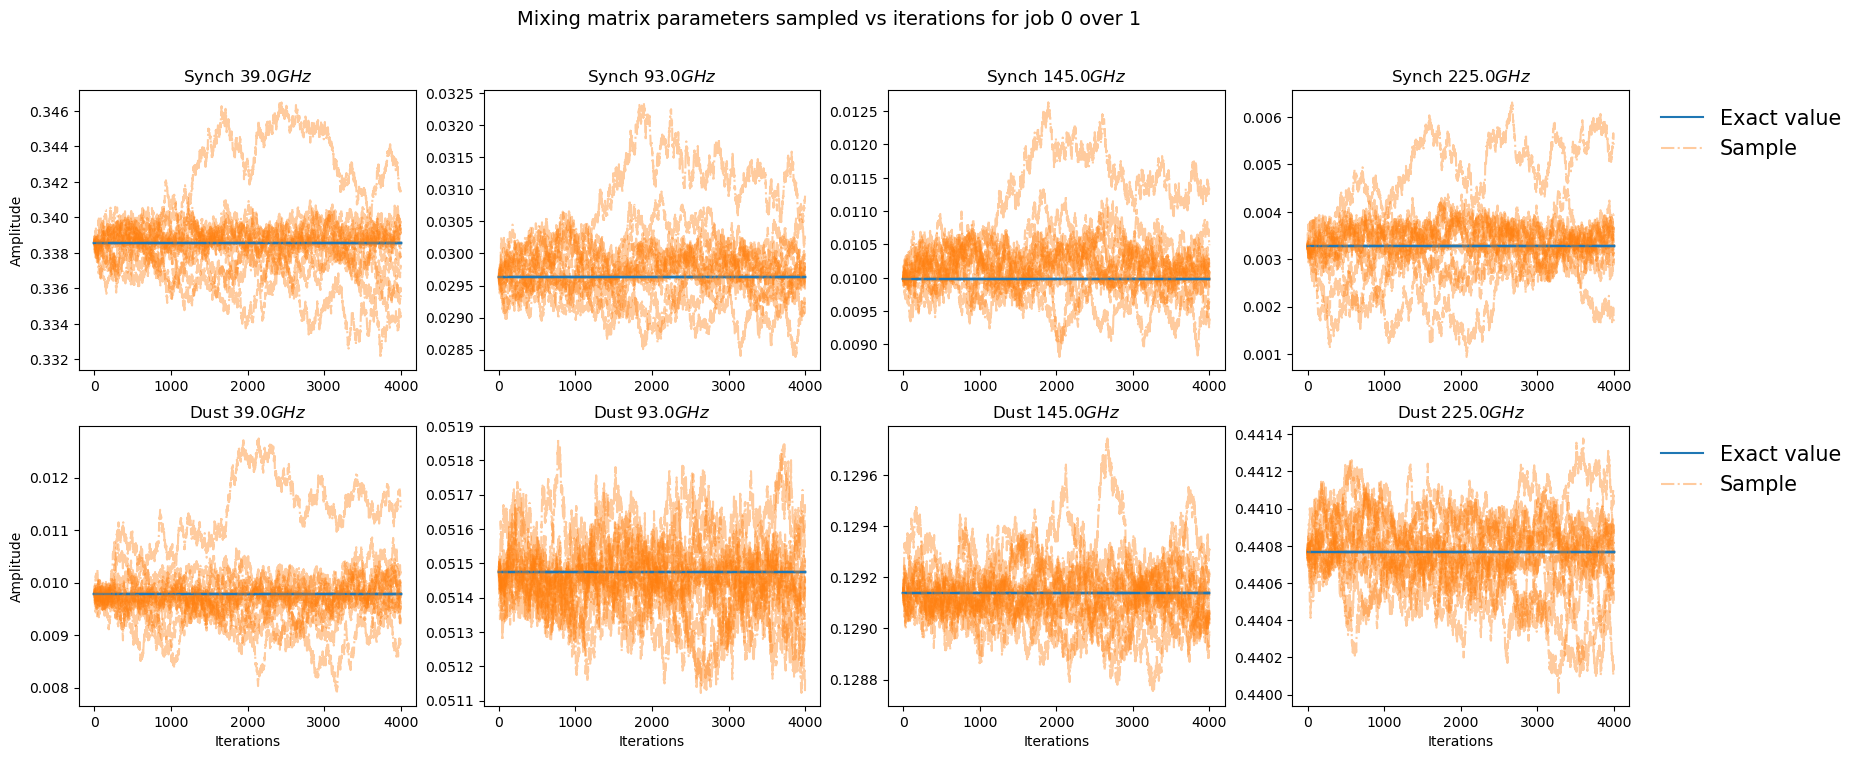

In [50]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = frequency_Bf.shape[0]

alpha_value = .4

if number_parameters_B_f_samples != number_params_B_f_nside0:
    for job in range(num_jobs):
        number_params_synch = MICMAC_sampler_obj.indexes_b[0,1]
        all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:number_params_synch]
        all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,number_params_synch:]

        frequency_array = np.array(instrument['frequency'])


        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            plt.figure(figsize=(20,8))
            plt.suptitle('Mixing matrix parameters sampled vs iterations for job {} over {}'.format(job,num_jobs), fontsize=14)
            # plt.subplot(121)

            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[MICMAC_sampler_obj.indexes_b[i,0]],init_params[MICMAC_sampler_obj.indexes_b[i,0]]], label='Exact value', color='tab:blue')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,MICMAC_sampler_obj.indexes_b[i,0]], '-.', color='tab:orange', label='Sample', alpha=alpha_value)
                
                for j in range(1,MICMAC_sampler_obj.size_patches[i]):
                    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[MICMAC_sampler_obj.indexes_b[i,0]+j],init_params[MICMAC_sampler_obj.indexes_b[i,0]+j]], color='tab:blue')
                    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,MICMAC_sampler_obj.indexes_b[i,0]+j], '-.', color='tab:orange', alpha=alpha_value)
                
                # n_sigma = 3
                # transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
                # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                # mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
                # std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

                # mean_value = all_B_f_sample_synch[:,i].mean()
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

                # plt.yscale('log')
                # plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

            # plt.figure(figsize=(20,8))
            # plt.subplot(122)
            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                # plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i+dim_Bf],init_params[i+dim_Bf]], label='Exact value')
                # plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[MICMAC_sampler_obj.indexes_b[i,1]],init_params[MICMAC_sampler_obj.indexes_b[i,1]]], label='Exact value', color='tab:blue')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,MICMAC_sampler_obj.indexes_b[i,1]], '-.', color='tab:orange', label='Sample', alpha=alpha_value)
                
                for j in range(1,MICMAC_sampler_obj.size_patches[i+number_params_synch]):
                    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[MICMAC_sampler_obj.indexes_b[i,1]+j],init_params[MICMAC_sampler_obj.indexes_b[i,1]+j]], color='tab:blue')
                    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,MICMAC_sampler_obj.indexes_b[i,1]+j], '-.', color='tab:orange', alpha=alpha_value)

                # n_sigma = 3
                # transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
                # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                # mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
                # std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

                # mean_value = all_B_f_sample_dust[:,i].mean()
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
                # plt.yscale('log')
                plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()
            

        plt.show()

In [51]:
mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[0,-1])
test_mixing_matrix = mixing_matrix_obj.get_B(jax_use=True)

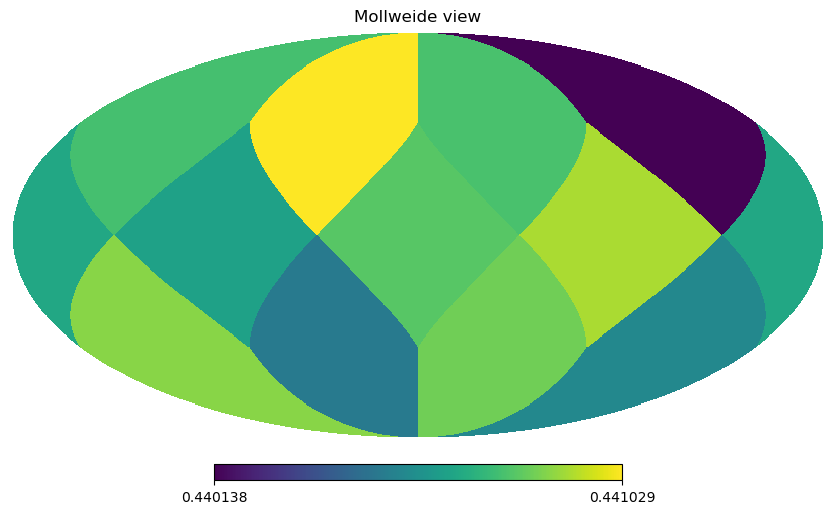

In [52]:
hp.mollview(test_mixing_matrix[4,2])

In [53]:
# all_params_mixing_matrix_samples[0,:,12:24].std(axis=0)
for i in range(8):
    print(all_params_mixing_matrix_samples[0,:,12*i:(i+1)*12].std(axis=0))

[0.00042317 0.00074987 0.00151974 0.0006104  0.0001577  0.00066767
 0.00053399 0.00105738 0.00066317 0.00100161 0.00262286 0.00065348]
[1.85809166e-04 2.76118771e-04 3.77533439e-04 2.21903892e-04
 5.70801158e-05 1.69337224e-04 1.82891752e-04 3.18675306e-04
 2.78802321e-04 2.68870983e-04 7.39226883e-04 2.21163058e-04]
[1.75848133e-04 2.38562874e-04 4.00760539e-04 2.35454210e-04
 5.82581706e-05 1.67716285e-04 1.76468465e-04 3.37605798e-04
 2.61817153e-04 2.69509219e-04 6.63623591e-04 2.21993208e-04]
[1.97152103e-04 3.08705709e-04 6.80168990e-04 2.77715930e-04
 6.91605594e-05 2.32388172e-04 2.22015306e-04 5.07221433e-04
 3.23268857e-04 4.51216862e-04 7.50635657e-04 2.52276089e-04]
[3.29578540e-04 2.48670065e-04 7.06347949e-04 3.00367858e-04
 8.30802998e-05 1.44073531e-04 1.07187338e-04 1.71559341e-04
 4.13797118e-04 3.20195753e-04 4.48829476e-04 2.50507109e-04]
[1.09372108e-04 6.46969455e-05 1.22467607e-04 9.10295703e-05
 2.71941044e-05 3.14313910e-05 3.20788649e-05 5.36823153e-05
 1.1583

In [54]:
all_params_mixing_matrix_samples[0,-1]

array([0.33952229, 0.33916645, 0.33447631, 0.33821841, 0.33839088,
       0.33719242, 0.33782682, 0.33571944, 0.3396574 , 0.33550242,
       0.34141797, 0.33917059, 0.02974116, 0.02960573, 0.02914154,
       0.0292253 , 0.02957546, 0.02968749, 0.02965641, 0.02952609,
       0.03023539, 0.02989571, 0.03090314, 0.02995709, 0.01023685,
       0.00995316, 0.00935454, 0.00968502, 0.00992688, 0.01009403,
       0.01026883, 0.01008075, 0.01050095, 0.01007702, 0.01135011,
       0.01015581, 0.00365417, 0.00358876, 0.0016931 , 0.00297758,
       0.00318968, 0.00325464, 0.00395513, 0.00321784, 0.00334859,
       0.00302491, 0.00541759, 0.00353007, 0.00957851, 0.0092442 ,
       0.01142983, 0.00960875, 0.00981293, 0.00996409, 0.00971111,
       0.00993706, 0.00885518, 0.0101858 , 0.00997686, 0.00950148,
       0.05155027, 0.05145563, 0.05116212, 0.05165377, 0.05146204,
       0.05134822, 0.05142919, 0.0515035 , 0.05130748, 0.05132727,
       0.05141389, 0.05139543, 0.12930497, 0.12913618, 0.12905

In [55]:
mixing_matrix_obj.update_params(init_params)
mixing_matrix_obj.params

array([0.33858815, 0.33858815, 0.33858815, 0.33858815, 0.33858815,
       0.33858815, 0.33858815, 0.33858815, 0.33858815, 0.33858815,
       0.33858815, 0.33858815, 0.02963068, 0.02963068, 0.02963068,
       0.02963068, 0.02963068, 0.02963068, 0.02963068, 0.02963068,
       0.02963068, 0.02963068, 0.02963068, 0.02963068, 0.00998213,
       0.00998213, 0.00998213, 0.00998213, 0.00998213, 0.00998213,
       0.00998213, 0.00998213, 0.00998213, 0.00998213, 0.00998213,
       0.00998213, 0.00328725, 0.00328725, 0.00328725, 0.00328725,
       0.00328725, 0.00328725, 0.00328725, 0.00328725, 0.00328725,
       0.00328725, 0.00328725, 0.00328725, 0.00979233, 0.00979233,
       0.00979233, 0.00979233, 0.00979233, 0.00979233, 0.00979233,
       0.00979233, 0.00979233, 0.00979233, 0.00979233, 0.00979233,
       0.05147511, 0.05147511, 0.05147511, 0.05147511, 0.05147511,
       0.05147511, 0.05147511, 0.05147511, 0.05147511, 0.05147511,
       0.05147511, 0.05147511, 0.12913911, 0.12913911, 0.12913

In [56]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

for job in range(num_jobs):
    all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:dim_Bf]
    all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,dim_Bf:]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        n_columns = 4
        number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//n_columns
            num_col = i%n_columns
            ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
            
            n_sigma = 3
            transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_synch[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            ax[num_row, num_col].set_xlabel('Iterations')
            if i == 0:
                # plt.ylabel('Amplitude')
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//n_columns
            num_col = i%n_columns
            ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

            n_sigma = 3
            transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_dust[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            
            if i == 0:
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

In [57]:
# for job in range(num_jobs):
#     all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:dim_Bf]
#     all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,dim_Bf:]

#     plt.figure(figsize=(14,4))
#     plt.suptitle('Relative error sampling vs iterations')
#     plt.subplot(121)
#     plt.title(('Synch parameters'))
#     for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
#         relative_error = np.abs((all_B_f_sample_synch[:,i]-init_params[i])/init_params[i])
#     #     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
#         # plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
#         plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.')
#     if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
#         plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
#     # plt.legend()
#     plt.yscale('log')
#     plt.xlabel('Iterations')
#     plt.ylabel('Relative error of B_f synch params')

#     plt.subplot(122)
#     plt.title(('Dust parameters'))
#     for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
#         relative_error = np.abs((all_B_f_sample_dust[:,i]-init_params[i+dim_Bf])/init_params[i+dim_Bf])
#     #     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
#         # plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
#         plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f"$B^f_{i}={frequency_array[i]} GHz$")
#     if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
#         plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
#     plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

#     plt.yscale('log')
#     plt.xlabel('Iterations')
#     plt.ylabel('Relative error of B_f dust params')
# plt.show()


In [58]:
all_params_mixing_matrix_samples.shape

(1, 4001, 96)

In [59]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']
if MICMAC_sampler_obj.len_params == (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf):
    for job in range(num_jobs):
        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
            plt.figure(figsize=(18,8))
            plt.suptitle(f"Mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)

            for i in range(len(frequency_Bf)):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job[:,i].min() == all_params_mixing_matrix_samples_job[:,i].max():
                    min_value = all_params_mixing_matrix_samples_job[:,i].min()*.9
                    max_value = all_params_mixing_matrix_samples_job[:,i].max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job[:,i].min()
                    max_value = all_params_mixing_matrix_samples_job[:,i].max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())
                # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
                plt.plot([init_params[i],init_params[i]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


            for i in range(len(frequency_Bf)):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                plt.title((f'Dust {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job[:,i+dim_Bf].min() == all_params_mixing_matrix_samples_job[:,i+dim_Bf].max():
                    min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()*.9
                    max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()
                    max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i+dim_Bf], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())

                # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
                plt.plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

        plt.show()


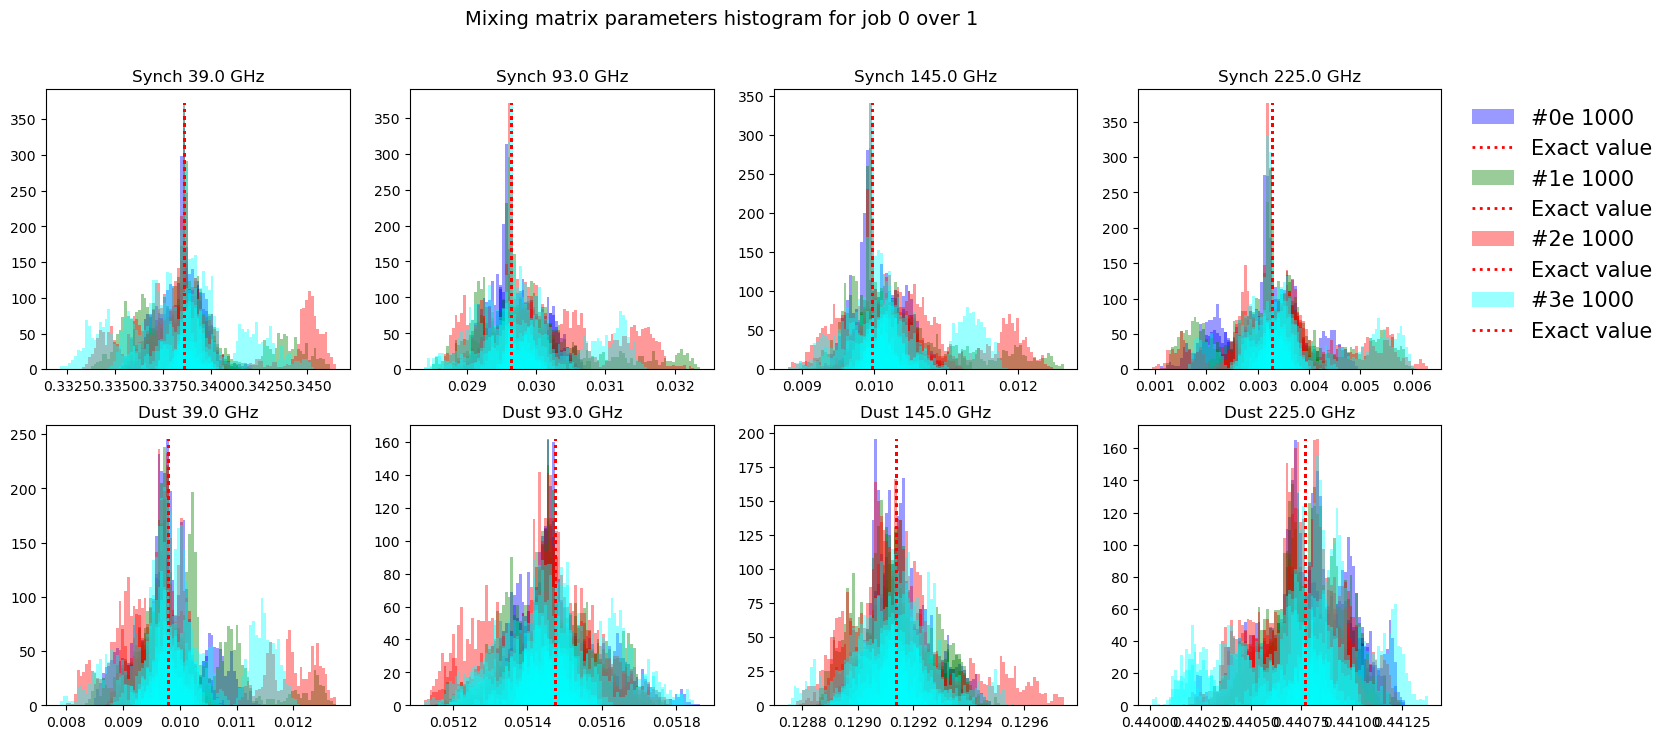

In [60]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

idx_patches = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*(MICMAC_sampler_obj.n_components - 1)+1)
idx_patches[:-1] = MICMAC_sampler_obj.indexes_b.ravel(order='F')
idx_patches[-1] = idx_patches[:-1].max() + MICMAC_sampler_obj.size_patches[-1]

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

alpha_value = .4

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']
if MICMAC_sampler_obj.len_params != (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf):
    for job in range(num_jobs):
        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            
            plt.figure(figsize=(18,8))
            plt.suptitle(f"Mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)

            for i in range(len(frequency_Bf)):
                idx_patch = np.arange(idx_patches[i],idx_patches[i+1], dtype=int)
                all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job,:,idx_patch].T
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job.min() == all_params_mixing_matrix_samples_job.max():
                    min_value = all_params_mixing_matrix_samples_job.min()*.9
                    max_value = all_params_mixing_matrix_samples_job.max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job.min()
                    max_value = all_params_mixing_matrix_samples_job.max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,0], bins=bins_array, color=color_list[j], alpha=alpha_value, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())
                    for k in range(1,len(idx_patch)):
                        heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,k], bins=bins_array, color=color_list[j], alpha=alpha_value)
                        max_height = max(max_height, heights.max())
                    plt.plot([init_params[idx_patch][0],init_params[idx_patch][0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
                    for k in range(1,len(idx_patch)):
                        plt.plot([init_params[idx_patch][k],init_params[idx_patch][k]], [0,max_height], 'r:', linewidth=2.0)
                # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
                
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


            for i in range(len(frequency_Bf)):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                plt.title((f'Dust {frequency_Bf[i]} GHz'))

                idx_patch = np.arange(idx_patches[i+dim_Bf],idx_patches[i+1+dim_Bf], dtype=int)
                dim_dust = MICMAC_sampler_obj.indexes_b[0,1]
                all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job,:,idx_patch].T
                if all_params_mixing_matrix_samples_job.min() == all_params_mixing_matrix_samples_job.max():
                    min_value = all_params_mixing_matrix_samples_job.min()*.9
                    max_value = all_params_mixing_matrix_samples_job.max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job.min()
                    max_value = all_params_mixing_matrix_samples_job.max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                # max_height = 0
                # for j in range(num_iter_1000):
                #     heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i+dim_Bf], bins=bins_array, color=color_list[j], alpha=.3, label=f'#{j}e {1000}')
                #     max_height = max(max_height, heights.max())
                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,0], bins=bins_array, color=color_list[j], alpha=alpha_value, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())
                    for k in range(1,len(idx_patch)):
                        heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,k], bins=bins_array, color=color_list[j], alpha=alpha_value)
                        max_height = max(max_height, heights.max())
                    # max_height = 1
                    plt.plot([init_params[idx_patch][0],init_params[idx_patch][0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
                    for k in range(1,len(idx_patch)):
                        plt.plot([init_params[idx_patch][k],init_params[idx_patch][k]], [0,max_height], 'r:', linewidth=2.0)

                # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
                # plt.plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

        plt.show()


In [61]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']

for job in range(num_jobs):
    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
        # plt.figure(figsize=(18,8))
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        fig.suptitle(f"Synch mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])
            

        for i in range(len(frequency_Bf)):
            num_row = i//n_columns
            num_col = i%n_columns
        
            # plt.subplot(201+len(frequency_Bf)*10+i)
            ax[num_row, num_col].set_title((f'Synch {frequency_Bf[i]} GHz'))
            # plt.title((f'Synch {frequency_Bf[i]} GHz'))
            if all_params_mixing_matrix_samples_job[:,i].min() == all_params_mixing_matrix_samples_job[:,i].max():
                min_value = all_params_mixing_matrix_samples_job[:,i].min()*.9
                max_value = all_params_mixing_matrix_samples_job[:,i].max()*1.1
            else:
                min_value = all_params_mixing_matrix_samples_job[:,i].min()
                max_value = all_params_mixing_matrix_samples_job[:,i].max()
            bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

            max_height = 0
            for j in range(num_iter_1000):
                heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                max_height = max(max_height, heights.max())
            # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
            ax[num_row, num_col].plot([init_params[i],init_params[i]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        fig.suptitle(f"Dust mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        for i in range(len(frequency_Bf)):
            num_row = i//n_columns
            num_col = i%n_columns
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            ax[num_row, num_col].set_title((f'Dust {frequency_Bf[i]} GHz'))
            if all_params_mixing_matrix_samples_job[:,i+dim_Bf].min() == all_params_mixing_matrix_samples_job[:,i+dim_Bf].max():
                min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()*.9
                max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()*1.1
            else:
                min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()
                max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()
            bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

            max_height = 0
            for j in range(num_iter_1000):
                heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i+dim_Bf], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                max_height = max(max_height, heights.max())

            # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
            ax[num_row, num_col].plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

    plt.show()


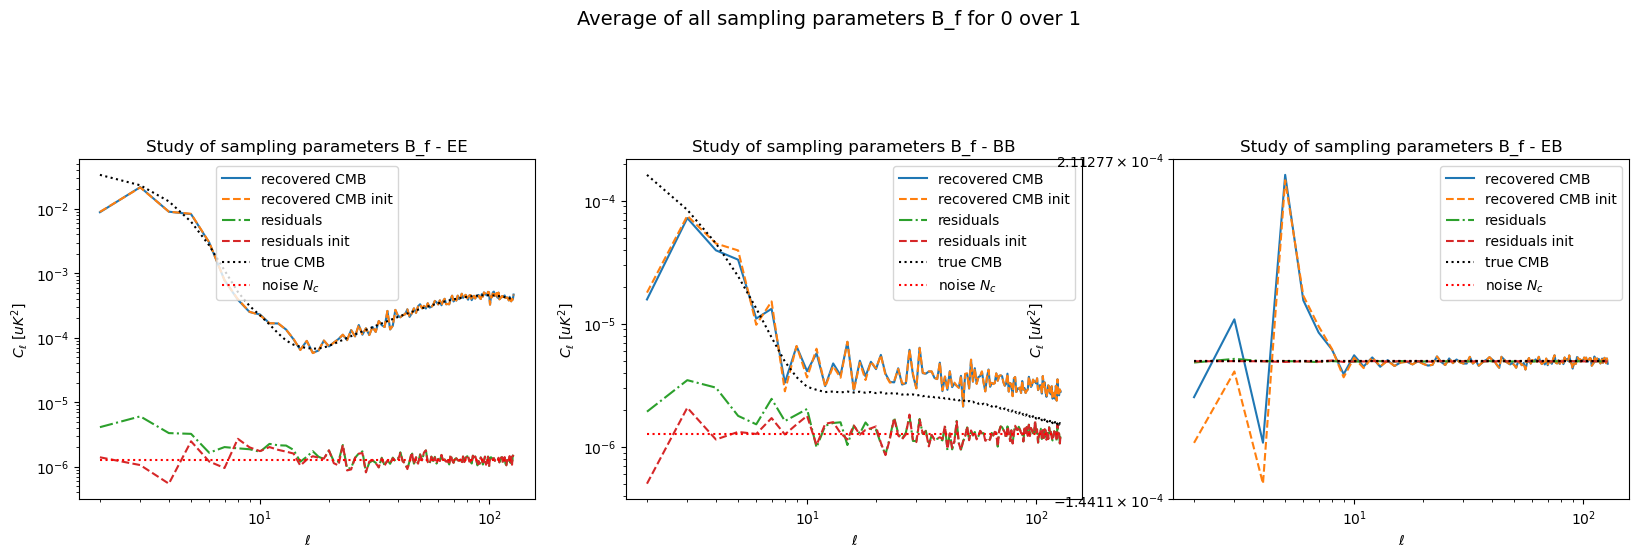

In [89]:
# Residuals power spectrum
for job in range(num_jobs):
    final_params = all_params_mixing_matrix_samples[job,-1]
    final_params = all_params_mixing_matrix_samples[job].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,1000:].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,-1000:].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,0]
    # final_params = all_params_mixing_matrix_samples[job,:1000].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,1000]
    # final_params = all_params_mixing_matrix_samples[job,:num_sample_AM].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,num_sample_AM:].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,2000:].mean(axis=0)

    mixing_matrix_obj.update_params(final_params)
    final_mixing_matrix = mixing_matrix_obj.get_B()

    _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix.mean(axis=2), lmax)[0,0,lmin:]
    red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
    cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

    recovered_CMB_Wd = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, final_mixing_matrix, initial_freq_maps[job], jax_use=False)[0, :, :]

    mixing_matrix_obj.update_params(init_params)
    init_mixing_matrix_obj = mixing_matrix_obj.get_B()
    recovered_CMB_Wd_init = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, init_mixing_matrix_obj, initial_freq_maps[job], jax_use=False)[0, :, :]

    residuals_Wd = recovered_CMB_Wd - input_cmb_maps[job,0]
    residuals_Wd_init = recovered_CMB_Wd_init - input_cmb_maps[job,0]

    recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
    c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    recovered_CMB_Wd_init_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_init[0]), recovered_CMB_Wd_init])
    c_ells_recovered_CMB_Wd_init = hp.anafast(recovered_CMB_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
    c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    residuals_Wd_init_extended = np.vstack([np.zeros_like(residuals_Wd_init[0]), residuals_Wd_init])
    c_ells_residuals_Wd_init = hp.anafast(residuals_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    plt.figure(figsize=(20,15))
    list_correl = ['EE', 'BB', 'EB']
    plt.suptitle(f"Average of all sampling parameters B_f for {job} over {num_jobs}", fontsize=14)
    number_subplots_convention = 331
    for i in range(n_correl_to_plot):
        plt.subplot(number_subplots_convention+i)
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label='recovered CMB')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd_init[i,:], '--', label='recovered CMB init')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd_init[i,:], '--', label='residuals init')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[i,:], 'k:', label='true CMB')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

        if i <= nstokes-1:
            plt.loglog()
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        else:
            plt.xscale('log')
            plt.yscale('symlog')
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.legend()
plt.show()

In [63]:
# estimated_params = all_params_mixing_matrix_samples[-1000:].mean(axis=0)
# estimated_std = all_params_mixing_matrix_samples[-1000:].std(axis=0)

# Fisher_uncertainty = np.diag(sp.linalg.sqrtm(np.linalg.pinv(Fisher_matrix)))[:-1]

# print("Number of iterations", MICMAC_sampler_obj.number_iterations_sampling)
# for i in range(estimated_params.shape[0]*2):
#     j = i%(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
#     k = i//(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
#     if i>=MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs:
#         print('$B^d$ :', frequency_array[j], 'GHz')
#     else:
#         print('$B^s$ :', frequency_array[j], 'GHz')
#     print('Estimated :', estimated_params[j,k], "+-", estimated_std[j,k], '; Fisher :', Fisher_uncertainty[i])
#     print('Init params :', init_params[j,k])

# Autocorrelation length study

In [64]:
import numpyro.diagnostics
# from emcee import autocorr


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.01      0.00      0.01      0.01      0.01    187.61      1.00



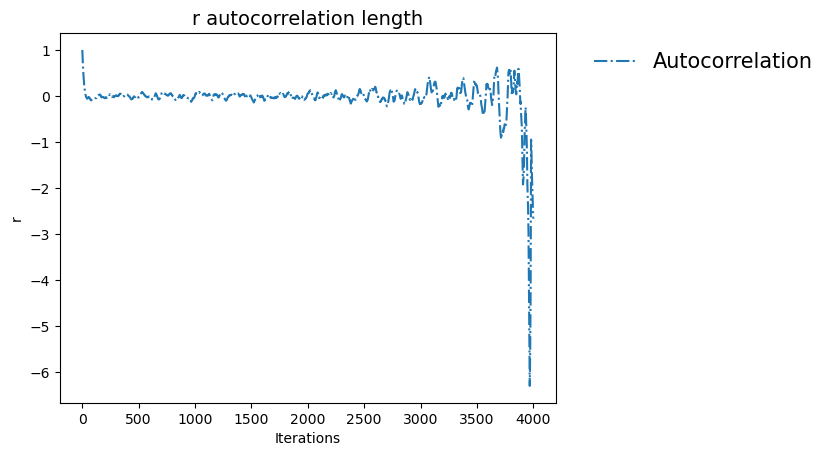

In [65]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        numpyro.diagnostics.print_summary(all_r_samples[job], prob=0.9, group_by_chain=False)
        aucorrelation_r = numpyro.diagnostics.autocorrelation(all_r_samples[job], axis=0)

        plt.figure()
        plt.title('r autocorrelation length', fontsize=14)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), aucorrelation_r, '-.', label='Autocorrelation')
        plt.xlabel('Iterations')
        plt.ylabel('r')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()


In [66]:
for job in range(num_jobs):
    aucorrelation_B_f = numpyro.diagnostics.autocorrelation(all_params_mixing_matrix_samples[job], axis=0)
    print(aucorrelation_B_f.shape)

(4001, 96)



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.34      0.00      0.34      0.34      0.34     40.75      1.03
 Param:0[1]      0.34      0.00      0.34      0.34      0.34     22.61      1.03
 Param:0[2]      0.34      0.00      0.34      0.33      0.34      4.29      1.52
 Param:0[3]      0.34      0.00      0.34      0.34      0.34     23.56      1.21
 Param:0[4]      0.34      0.00      0.34      0.34      0.34    122.77      1.01
 Param:0[5]      0.34      0.00      0.34      0.34      0.34     19.28      1.07
 Param:0[6]      0.34      0.00      0.34      0.34      0.34     36.59      1.10
 Param:0[7]      0.34      0.00      0.34      0.34      0.34     14.57      1.00
 Param:0[8]      0.34      0.00      0.34      0.34      0.34     12.98      1.01
 Param:0[9]      0.34      0.00      0.34      0.34      0.34     12.43      1.14
Param:0[10]      0.34      0.00      0.34      0.34      0.35      3.85      1.35
Param:0[11]    

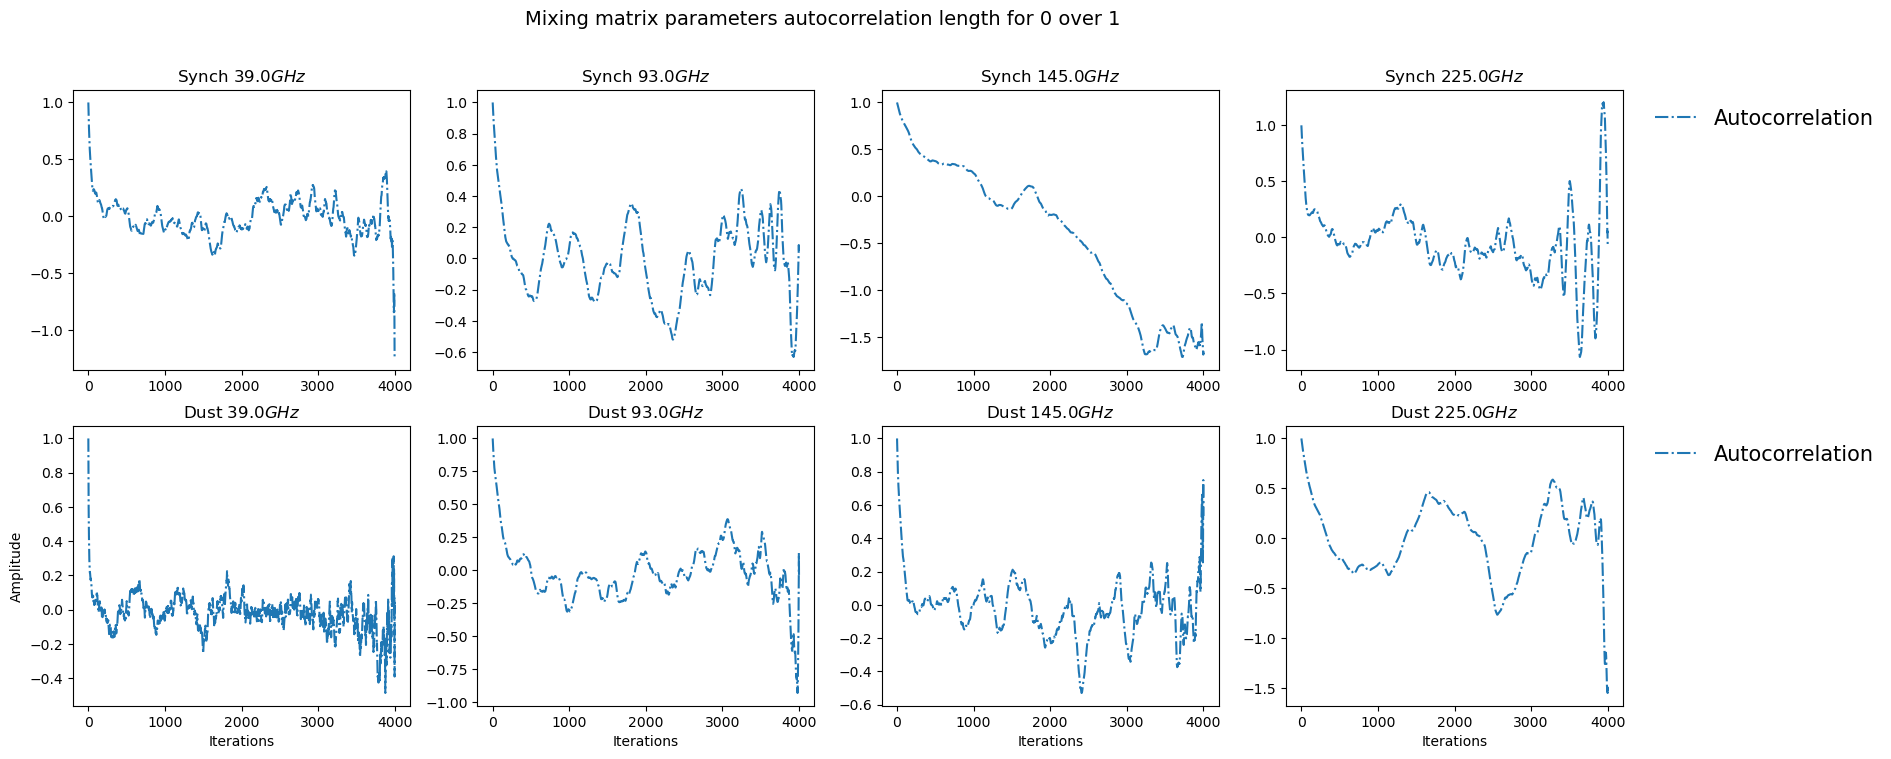

In [67]:
for job in range(num_jobs):
    aucorrelation_B_f = numpyro.diagnostics.autocorrelation(all_params_mixing_matrix_samples[job], axis=0)
    numpyro.diagnostics.print_summary(all_params_mixing_matrix_samples[job], prob=0.9, group_by_chain=False)

    list_correl = ['EE', 'BB', 'EB']

    ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

    frequency_Bf = np.array(instrument['frequency'][1:-1])
    all_B_f_autocorr_synch = aucorrelation_B_f[:,:dim_Bf]
    all_B_f_autocorr_dust = aucorrelation_B_f[:,dim_Bf:]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
        plt.figure(figsize=(20,8))
        plt.suptitle(f"Mixing matrix parameters autocorrelation length for {job} over {num_jobs}", fontsize=14)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_synch[:,i], '-.', label='Autocorrelation')
            
            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            # mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            # std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            # mean_value = all_B_f_sample_synch[:,i].mean()
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            # if i == 0:
            #     plt.ylabel('Amplitude')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_dust[:,i], '-.', label='Autocorrelation')

            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            # mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            # std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            # mean_value = all_B_f_sample_dust[:,i].mean()
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            plt.xlabel('Iterations')
            if i == 0:
                plt.ylabel('Amplitude')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

In [68]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

for job in range(num_jobs):
    # all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:,0]
    # all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,:,1]

    all_B_f_autocorr_synch = aucorrelation_B_f[:,:dim_Bf]
    all_B_f_autocorr_dust = aucorrelation_B_f[:,dim_Bf:]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        n_columns = 4
        number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"Mixing matrix synch autocorrelation length vs iterations for job {job} over {num_jobs}", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//n_columns
            num_col = i%n_columns
            ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_synch[:,i], '-.', label='Sample')
            
            # plt.yscale('log')
            # plt.xlabel('Iterations')
            # ax[num_row, num_col].set_xlabel('Iterations')
            if i == 0:
                # plt.ylabel('Amplitude')
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Mixing matrix dust autocorrelation length vs iterations for job {job} over {num_jobs}", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//n_columns
            num_col = i%n_columns
            ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_dust[:,i], '-.', label='Sample')

            # plt.yscale('log')
            if i == 0:
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

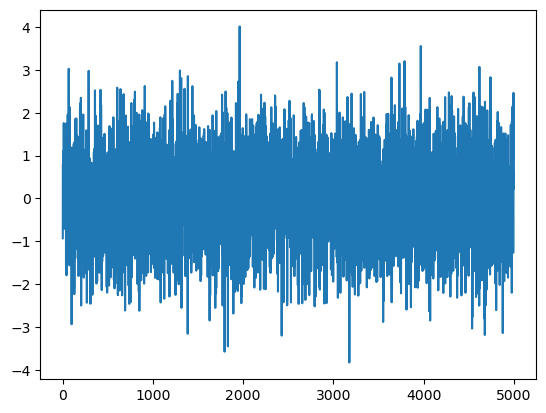

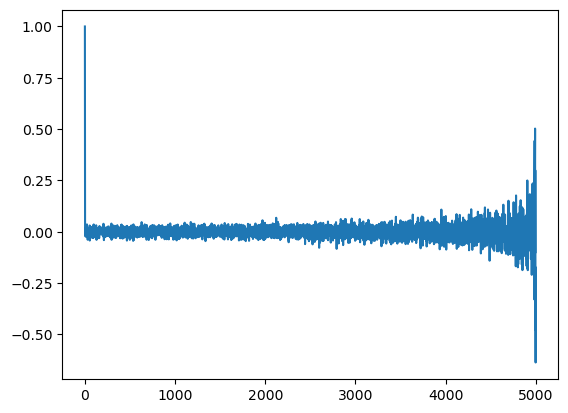

In [69]:
# Test on what to expect for autocorrelation
test_random = np.random.randn(5000)
# test_random = np.ones(1000)
# for i in range(10):
#     test_random[i*100:i*100 + 50] = -1
aucorr_random = numpyro.diagnostics.autocorrelation(test_random, axis=0)

plt.figure()
plt.plot(np.arange(test_random.shape[0]), test_random)
plt.figure()
plt.plot(np.arange(aucorr_random.shape[0]), aucorr_random)
plt.show()

In [70]:
for job in range(num_jobs):
    numpyro.diagnostics.effective_sample_size(jnp.array([all_params_mixing_matrix_samples[job,:]]))

In [71]:
all_r_samples.mean()

0.010764098201519788

In [72]:
all_r_samples.shape

(1, 4001)

In [73]:
micmac.get_Gelman_Rubin_statistics(all_r_samples).mean()

1.0

In [74]:
micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples).mean(axis=0)

1.0000000000000002

# Plotting Gelman-Rubin every 100 samples

In [75]:
micmac.get_Gelman_Rubin_statistics(all_r_samples[:,-1000:]).mean()

1.0

In [76]:
for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    print('Freq', MICMAC_sampler_obj.frequency_array[freq], 'GHz :', micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-1000:, freq]))#.mean(axis=0)

Freq 27.0 GHz : 1.0
Freq 39.0 GHz : 1.0
Freq 93.0 GHz : 1.0
Freq 145.0 GHz : 1.0


In [77]:
for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    print('Freq', MICMAC_sampler_obj.frequency_array[freq], 'GHz :', micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-1000:, freq+dim_Bf]))#.mean(axis=0)

Freq 27.0 GHz : 1.0
Freq 39.0 GHz : 1.0
Freq 93.0 GHz : 1.0
Freq 145.0 GHz : 1.0


In [78]:
if num_jobs > 1:
    num_GR = 1000
    treshold_GR = 0.1

    r_Gelman_Rubin = np.zeros(MICMAC_sampler_obj.number_iterations_sampling+1-num_GR)
    B_f_s_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_GR))
    B_f_d_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_GR))
    for iteration in range(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1):
        r_Gelman_Rubin[iteration-num_GR] = micmac.get_Gelman_Rubin_statistics(all_r_samples[:,-num_GR+iteration:iteration])[0]
        for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            B_f_s_Gelman_Rubin[freq,iteration-num_GR] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-num_GR+iteration:iteration,freq])
            B_f_d_Gelman_Rubin[freq,iteration-num_GR] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-num_GR+iteration:iteration,freq+dim_Bf])

    frequency_Bf = np.array(instrument['frequency'][1:-1])

    plt.figure(figsize=(14,4))
    plt.title(f"Gelman-Rubin statistics evolution for the last {num_GR} iterations over {num_jobs} jobs", fontsize=14)
    plt.plot(np.arange(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1), r_Gelman_Rubin, label='r')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_s_Gelman_Rubin[freq,:], label=f'B_synch {frequency_Bf[freq]} GHz')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_d_Gelman_Rubin[freq,:], label=f'B_dust {frequency_Bf[freq]} GHz')
    
    plt.plot([num_GR,MICMAC_sampler_obj.number_iterations_sampling+1], [treshold_GR,treshold_GR], 'k:', label='Treshold')
    plt.xlabel('Iterations done')
    plt.ylabel('Gelman-Rubin statistics')
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()
        

In [79]:
if num_jobs > 1:
    num_burnin = 500
    treshold_GR = 0.1

    r_Gelman_Rubin = np.zeros(MICMAC_sampler_obj.number_iterations_sampling+1-num_burnin)
    B_f_s_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_burnin))
    B_f_d_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_burnin))
    for iteration in range(num_burnin+1,MICMAC_sampler_obj.number_iterations_sampling+1):
        r_Gelman_Rubin[iteration-num_burnin-1] = micmac.get_Gelman_Rubin_statistics(all_r_samples[:,num_burnin:iteration])[0]
        for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            B_f_s_Gelman_Rubin[freq,iteration-num_burnin-1] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,num_burnin:iteration,freq,0])
            B_f_d_Gelman_Rubin[freq,iteration-num_burnin-1] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,num_burnin:iteration,freq,1])

    frequency_Bf = np.array(instrument['frequency'][1:-1])

    plt.figure(figsize=(14,4))
    plt.title(f"Gelman-Rubin statistics evolution from {num_burnin} iterations to the the last over {num_jobs} jobs", fontsize=14)
    plt.plot(np.arange(num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1), r_Gelman_Rubin, label='r')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_s_Gelman_Rubin[freq,:], label=f'B_synch {frequency_Bf[freq]} GHz')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_d_Gelman_Rubin[freq,:], label=f'B_dust {frequency_Bf[freq]} GHz')
    
    plt.plot([num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1], [treshold_GR,treshold_GR], 'k:', label='Treshold')
    plt.xlabel('Iterations done')
    plt.ylabel('Gelman-Rubin statistics')
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()
        

In [80]:
def MH_test(old_sample, indexes_Bf):
        
    def map_func(carry, index_Bf):
        
        sample_proposal = carry['sample'][index_Bf] + index_Bf

        proposal_params = jnp.copy(carry['sample'], order='K')
        proposal_params = proposal_params.at[index_Bf].set(sample_proposal)

        new_carry = {'sample':proposal_params}
        return new_carry, sample_proposal
        # return (rng_key, proposal_params), new_param

    initial_carry = {'sample':old_sample}
    # carry, new_params = jlax.scan(map_func, (random_PRNGKey, jnp.ravel(old_sample,order='F')), indexes_Bf)
    last_carry, new_params = jlax.scan(map_func, initial_carry, indexes_Bf)
    # new_sample = jnp.copy(old_sample, order='K')
    # new_sample = new_sample.at[indexes_Bf].set(new_params)
    new_sample = jnp.copy(last_carry['sample'], order='K')

    # latest_PRNGKey = carry[0]
    # latest_PRNGKey = last_carry['PRNGKey']
    # return latest_PRNGKey, new_sample.reshape(old_sample.shape,order='F')
    return new_sample


In [81]:
test_params = jnp.copy(jnp.arange(MICMAC_sampler_obj.len_params), order='K')

indexes_Bf = MICMAC_sampler_obj.indexes_free_Bf

In [82]:
indexes_Bf

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64)

In [83]:
test_params, test_params[indexes_Bf]

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64),
 Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64))

In [84]:
new_sample = MH_test(test_params, indexes_Bf)

In [85]:
(new_sample-test_params)

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64)

In [152]:
def MH_test_v3(old_sample, indexes_Bf, indexes_patches_Bf, size_patches, max_len_patches_Bf, len_indexes_Bf):
    """  
        Perform Metroplis-Hasting step for a given set of indexes given by indexes_patches_Bf
        
        Parameters
        ----------
        :param random_PRNGKey: random key for the random number generator ; note it will be split for each sample indexed by indexes B_f
        :param old_sample: old sample to be updated
        :param step_size: step size for all B_f
        :param log_proba: log probability function as log(p(x) (and not -log(p(x)) as in the previous version)
        :param indexes_Bf: all indexes of the parameters to be updated
        :param indexes_patches_Bf: indexes of the parameters to be updated, corresponding to first indexes of params per patch
        :param indexes_patches_B_f: indexes of the patches to be updated
        :param model_kwargs: additional arguments for the log_proba function

        Returns
        -------
        :return: latest_PRNGKey, new_sample
    """

    def map_func(carry, index_Bf):
        indexes_to_consider = ((index_Bf + jnp.arange(max_len_patches_Bf, dtype=jnp.int32))%len_indexes_Bf).astype(jnp.int64)
        mask_in_indexes_B_f = jnp.where(jnp.isin(index_Bf + jnp.arange(max_len_patches_Bf, dtype=jnp.int32), indexes_Bf), 1, 0)
        mask_indexes_to_consider = jnp.where(jnp.arange(max_len_patches_Bf) < size_patches[index_Bf], 1, 0)*mask_in_indexes_B_f

        sample_proposal = carry['sample'][indexes_to_consider] + .1*mask_indexes_to_consider

        proposal_params = jnp.copy(carry['sample'])
        proposal_params = proposal_params.at[indexes_to_consider].set(sample_proposal)


        new_carry = {'sample':proposal_params}
        return new_carry, sample_proposal

    initial_carry = {'sample':old_sample}

    carry, new_params = jlax.scan(map_func, initial_carry, indexes_patches_Bf)

    new_sample = carry['sample']
    return new_sample, new_params


In [153]:
test_params = jnp.copy(jnp.arange(MICMAC_sampler_obj.len_params), order='K')

indexes_Bf = MICMAC_sampler_obj.indexes_free_Bf
indexes_Bf

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64)

In [154]:
test_params, test_params[indexes_Bf]

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64),
 Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64))

In [155]:
indexes_patches_Bf[-1] + size_patches[-1]

Array(96, dtype=int64)

In [203]:
%%time
indexes_patches_Bf = np.array(MICMAC_sampler_obj.indexes_b.ravel(order='F'), dtype=np.int64)
size_patches = MICMAC_sampler_obj.size_patches
# size_patches = jnp.ones_like(MICMAC_sampler_obj.size_patches)
max_len_patches_Bf = int(np.max(size_patches))
len_indexes_Bf = indexes_patches_Bf[-1] + size_patches[-1]

indexes_Bf_2 = jnp.array([3,18,22,64,65,66,94])
# indexes_Bf_2 = jnp.array([42])

def which_interval(carry, index_Bf):
    return carry | ((index_Bf >= indexes_patches_Bf) & (index_Bf < indexes_patches_Bf + size_patches)), index_Bf

condition, _ = jlax.scan(which_interval, jnp.zeros_like(MICMAC_sampler_obj.size_patches, dtype=bool), indexes_Bf_2)

print(condition)
# condition = (indexes_Bf_2 >= indexes_patches_Bf) & (indexes_Bf_2 < indexes_patches_Bf + size_patches)

indexes_current_patches_Bf = indexes_patches_Bf[condition]

# new_sample_v3, test_ = MH_test_v3(jnp.array(test_params,dtype=float), indexes_Bf, indexes_patches_Bf, size_patches, max_len_patches_Bf, len_indexes_Bf)
new_sample_v3, test_ = MH_test_v3(jnp.array(test_params,dtype=float), indexes_Bf_2, indexes_patches_Bf, size_patches, max_len_patches_Bf, len_indexes_Bf)


CPU times: user 156 ms, sys: 4.18 ms, total: 160 ms
Wall time: 162 ms


In [205]:
indexes_patches_Bf, (42 >= indexes_patches_Bf) & (42 < indexes_patches_Bf + size_patches)

(array([ 0, 12, 24, 36, 48, 60, 72, 84]),
 Array([False, False, False,  True, False, False, False, False], dtype=bool))

In [206]:
new_sample_v3

Array([ 0. ,  1. ,  2. ,  3.1,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
       11. , 12. , 13. , 14. , 15. , 16. , 17. , 18.1, 19. , 20. , 21. ,
       22.1, 23. , 24. , 25. , 26. , 27. , 28. , 29. , 30. , 31. , 32. ,
       33. , 34. , 35. , 36. , 37. , 38. , 39. , 40. , 41. , 42. , 43. ,
       44. , 45. , 46. , 47. , 48. , 49. , 50. , 51. , 52. , 53. , 54. ,
       55. , 56. , 57. , 58. , 59. , 60. , 61. , 62. , 63. , 64.1, 65.1,
       66.1, 67. , 68. , 69. , 70. , 71. , 72. , 73. , 74. , 75. , 76. ,
       77. , 78. , 79. , 80. , 81. , 82. , 83. , 84. , 85. , 86. , 87. ,
       88. , 89. , 90. , 91. , 92. , 93. , 94.1, 95. ], dtype=float64)

In [167]:
test_

Array([[ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
        11. ],
       [12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. ,
        23. ],
       [24. , 25. , 26. , 27. , 28. , 29. , 30. , 31. , 32. , 33. , 34. ,
        35. ],
       [36. , 37. , 38. , 39. , 40. , 41. , 42.1, 43. , 44. , 45. , 46. ,
        47. ],
       [48. , 49. , 50. , 51. , 52. , 53. , 54. , 55. , 56. , 57. , 58. ,
        59. ],
       [60. , 61. , 62. , 63. , 64. , 65. , 66. , 67. , 68. , 69. , 70. ,
        71. ],
       [72. , 73. , 74. , 75. , 76. , 77. , 78. , 79. , 80. , 81. , 82. ,
        83. ],
       [84. , 85. , 86. , 87. , 88. , 89. , 90. , 91. , 92. , 93. , 94. ,
        95. ]], dtype=float64)

In [168]:
new_sample_v3 - test_params

Array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. ], dtype=float64)